In [1]:
import pickle

import numpy as np
from astropy.table import Table

%matplotlib inline
from matplotlib import pyplot as plt

from scipy.stats import gaussian_kde
from scipy.optimize import leastsq, least_squares

from tqdm.notebook import tqdm

In [2]:
ls

01334/  01441/  gdrive  magmag.ipynb  merged_catalogs/  res.pickle  venv/


In [3]:
m92_cat = Table.read('merged_catalogs/M92_all_columns.csv', format='csv')

In [4]:
def m92_chip_number(data, xvar='x', yvar='y'):
    data = data.copy()
    if 'x' in data.colnames:
        data['xx'] = data['x']
        data.remove_column('x')
    if 'y' in data.colnames:
        data['yy'] = data['y']
        data.remove_column('y')
        
    data['x'] = data[xvar]
    data['y'] = data[yvar]
    
    chipnum = np.empty(len(data['x']), dtype='U2')
    # LONG LINE ACROSS CENTER
    x=np.arange(0,10000,1)
    m1 = (5722-4126)/(479-9849)
    b1 = 5722 - m1*(479)
    y1=m1*x+b1
    # FIRST
    x2=np.arange(1900,3000)
    m2 = (7445-3445)/(2821-2114)
    b2 = 7445 - 2821*m2
    y2=m2*x2+b2
    # SECOND
    x3 = np.arange(4500,6000)
    m3 = (7064-2976)/(5664 - 4806)
    b3 = 7064 - 5664*m3
    y3=m3*x3+b3
    # THIRD
    x4=np.arange(7500,8300)
    m4 = (6561-2552)/(8222-7498)
    b4 = 6561 - 8222*m4
    y4=m4*x4+b4
    yc1 = m1*data['x'] + b1
    yc2 = m2*data['x'] + b2
    yc3 = m3*data['x'] + b3
    yc4 = m4*data['x'] + b4
    # CHIP B2
    mb2 = (data['y'] > yc1) & (data['y'] > yc2)
    chipnum[mb2] = 'b2'
    # CHIP B1
    mb1 = (data['y'] < yc1) & (data['y'] > yc2)
    chipnum[mb1] = 'b1'
    # CHIP B4
    mb4 = (data['y'] > yc1) & (data['y'] < yc2) & (data['y'] > yc3)
    chipnum[mb4] = 'b4'
    # CHIP B3
    mb3 = (data['y'] < yc1) & (data['y'] < yc2) & (data['y'] > yc3)
    chipnum[mb3] = 'b3'
    # CHIP A3
    ma3 = (data['y'] > yc1)    & (data['y'] > yc4)& (data['y'] < yc3)
    chipnum[ma3] = 'a3'
    # CHIP A4
    ma4 = (data['y'] < yc1)    & (data['y'] > yc4)& (data['y'] < yc3)
    chipnum[ma4] = 'a4'
    # CHIP A1
    ma1 = (data['y'] > yc1)    & (data['y']< yc4)
    chipnum[ma1] = 'a1'
    # CHIP A2
    ma2 = (data['y'] < yc1)    & (data['y']< yc4)
    chipnum[ma2] = 'a2'
    return chipnum

m92_cat['chipnum_090'] = m92_chip_number(m92_cat, 'F090W_xbar', 'F090W_ybar')
m92_cat['chipnum_150'] = m92_chip_number(m92_cat, 'F150W_xbar', 'F150W_ybar')
m92_cat

RA,Dec,F444W_xbar,F444W_ybar,F444W_mbar,F444W_xsig,F444W_ysig,F444W_msig,F444W_qbar,F444W_Nf,F444W_Ng,F444W_Nm,F444W_Nmin,F444W_Nstar,F444W_pki,F444W_pkj,F444W_pkp,F444W_pkn,F444W_pku,F090W_xbar,F090W_ybar,F090W_mbar,F090W_xsig,F090W_ysig,F090W_msig,F090W_qbar,F090W_Nf,F090W_Ng,F090W_Nm,F090W_Nmin,F090W_Nstar,F090W_pki,F090W_pkj,F090W_pkp,F090W_pkn,F090W_pku,F277W_xbar,F277W_ybar,F277W_mbar,F277W_xsig,F277W_ysig,F277W_msig,F277W_qbar,F277W_Nf,F277W_Ng,F277W_Nm,F277W_Nmin,F277W_Nstar,F277W_pki,F277W_pkj,F277W_pkp,F277W_pkn,F277W_pku,F150W_xbar,F150W_ybar,F150W_mbar,F150W_xsig,F150W_ysig,F150W_msig,F150W_qbar,F150W_Nf,F150W_Ng,F150W_Nm,F150W_Nmin,F150W_Nstar,F150W_pki,F150W_pkj,F150W_pkp,F150W_pkn,F150W_pku,chipnum_090,chipnum_150
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str7,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str7,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str7,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str7,int64,int64,int64,int64,int64,str2,str2
259.227251760848,43.11066180482311,9397.1771,2157.1069,0.0,9.0,9.0,9.0,0.0,0,0,0,3,N000001,9397,2157,1,1,3,9397.1668,2157.0674,-3.1377,0.0144,0.0102,0.0817,0.168,4,3,4,3,N000001,9397,2157,1,1,3,9397.1771,2157.1069,0.0,9.0,9.0,9.0,0.0,0,0,0,3,N000001,9397,2157,1,1,3,9397.1771,2157.1069,-3.6503,0.004,0.0156,0.0252,0.0872,4,4,4,3,N000001,9396,2156,32,4,3,a2,a2
259.2265212518353,43.11070106547709,9457.1702,2161.5623,0.0,9.0,9.0,9.0,0.0,0,0,0,3,N000002,9457,2162,1,1,3,9457.1624,2161.5996,-4.1948,0.0115,0.0076,0.0605,0.059,4,3,4,3,N000002,9457,2162,1,1,3,9457.1702,2161.5623,0.0,9.0,9.0,9.0,0.0,0,0,0,3,N000002,9457,2162,1,1,3,9457.1702,2161.5623,-4.595,0.0083,0.0128,0.02,0.0462,4,4,4,3,N000002,9456,2161,32,4,3,a2,a2
259.2279837384394,43.11075669305671,9337.0538,2167.7437,0.0,9.0,9.0,9.0,0.0,0,0,0,3,N000003,9337,2168,1,1,3,0.0,0.0,0.0,9.0,9.0,9.0,0.0,2,0,0,3,N000003,9337,2168,1,1,3,9337.0538,2167.7437,0.0,9.0,9.0,9.0,0.0,0,0,0,3,N000003,9337,2168,1,1,3,9337.0538,2167.7437,-1.9487,0.0476,0.049,0.0225,0.181,4,4,4,3,N000003,9336,2167,32,4,3,b1,a2
259.2266279811688,43.110760671406766,9448.4003,2168.2623,0.0,9.0,9.0,9.0,0.0,0,0,0,3,N000004,9448,2168,1,1,3,9448.3954,2168.2789,-4.3045,0.01,0.0094,0.0343,0.0753,4,3,4,3,N000004,9448,2168,1,1,3,9448.4003,2168.2623,0.0,9.0,9.0,9.0,0.0,0,0,0,3,N000004,9448,2168,1,1,3,9448.4003,2168.2623,-4.7185,0.0085,0.0031,0.0273,0.0838,4,4,4,3,N000004,9447,2167,32,4,3,a2,a2
259.22847354365274,43.11076466746203,9296.8261,2168.6156,0.0,9.0,9.0,9.0,0.0,0,0,0,3,N000005,9297,2169,1,1,3,0.0,0.0,0.0,9.0,9.0,9.0,0.0,2,0,0,3,N000005,9297,2169,1,1,3,9296.8261,2168.6156,0.0,9.0,9.0,9.0,0.0,0,0,0,3,N000005,9297,2169,1,1,3,9296.8261,2168.6156,-7.4853,0.0043,0.0031,0.0223,0.0327,3,3,3,3,N000005,9296,2168,32,3,3,b1,a2
259.22679035573884,43.11079051586772,0.0,0.0,0.0,9.0,9.0,9.0,0.0,1,0,0,3,N000006,9435,2172,1,1,3,9435.0885,2171.6082,-8.2457,0.0059,0.0072,0.0053,0.0537,3,3,3,3,N000006,9435,2172,1,1,3,0.0,0.0,0.0,9.0,9.0,9.0,0.0,1,0,0,3,N000006,9435,2172,1,1,3,9435.0625,2171.6112,-8.1407,0.0039,0.0044,0.0043,0.0375,4,4,4,3,N000006,9434,2171,32,4,3,a2,a2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259.3314565695988,43.15987605512437,842.3491,7693.707,-7.2987,0.0363,0.0273,0.0963,0.109,3,3,3,3,N089147,842,7694,1,1,3,842.2888,7693.5724,-4.7235,0.0148,0.0023,0.028,0.0873,4,4,4,3,N089147,842,7694,1,1,3,842.3826,7693.7161,-8.193,0.0262,0.0061,0.013,0.0513,3,3,3,3,N089147,842,7694,1,1,3,842.2914,7693.5638,-5.1335,0.0091,0.01,0.0077,0.065,4,4,4,3,N089147,841,7693,32,4,3,b2,b2
259.3293133323749,

In [38]:
!xdg-open .

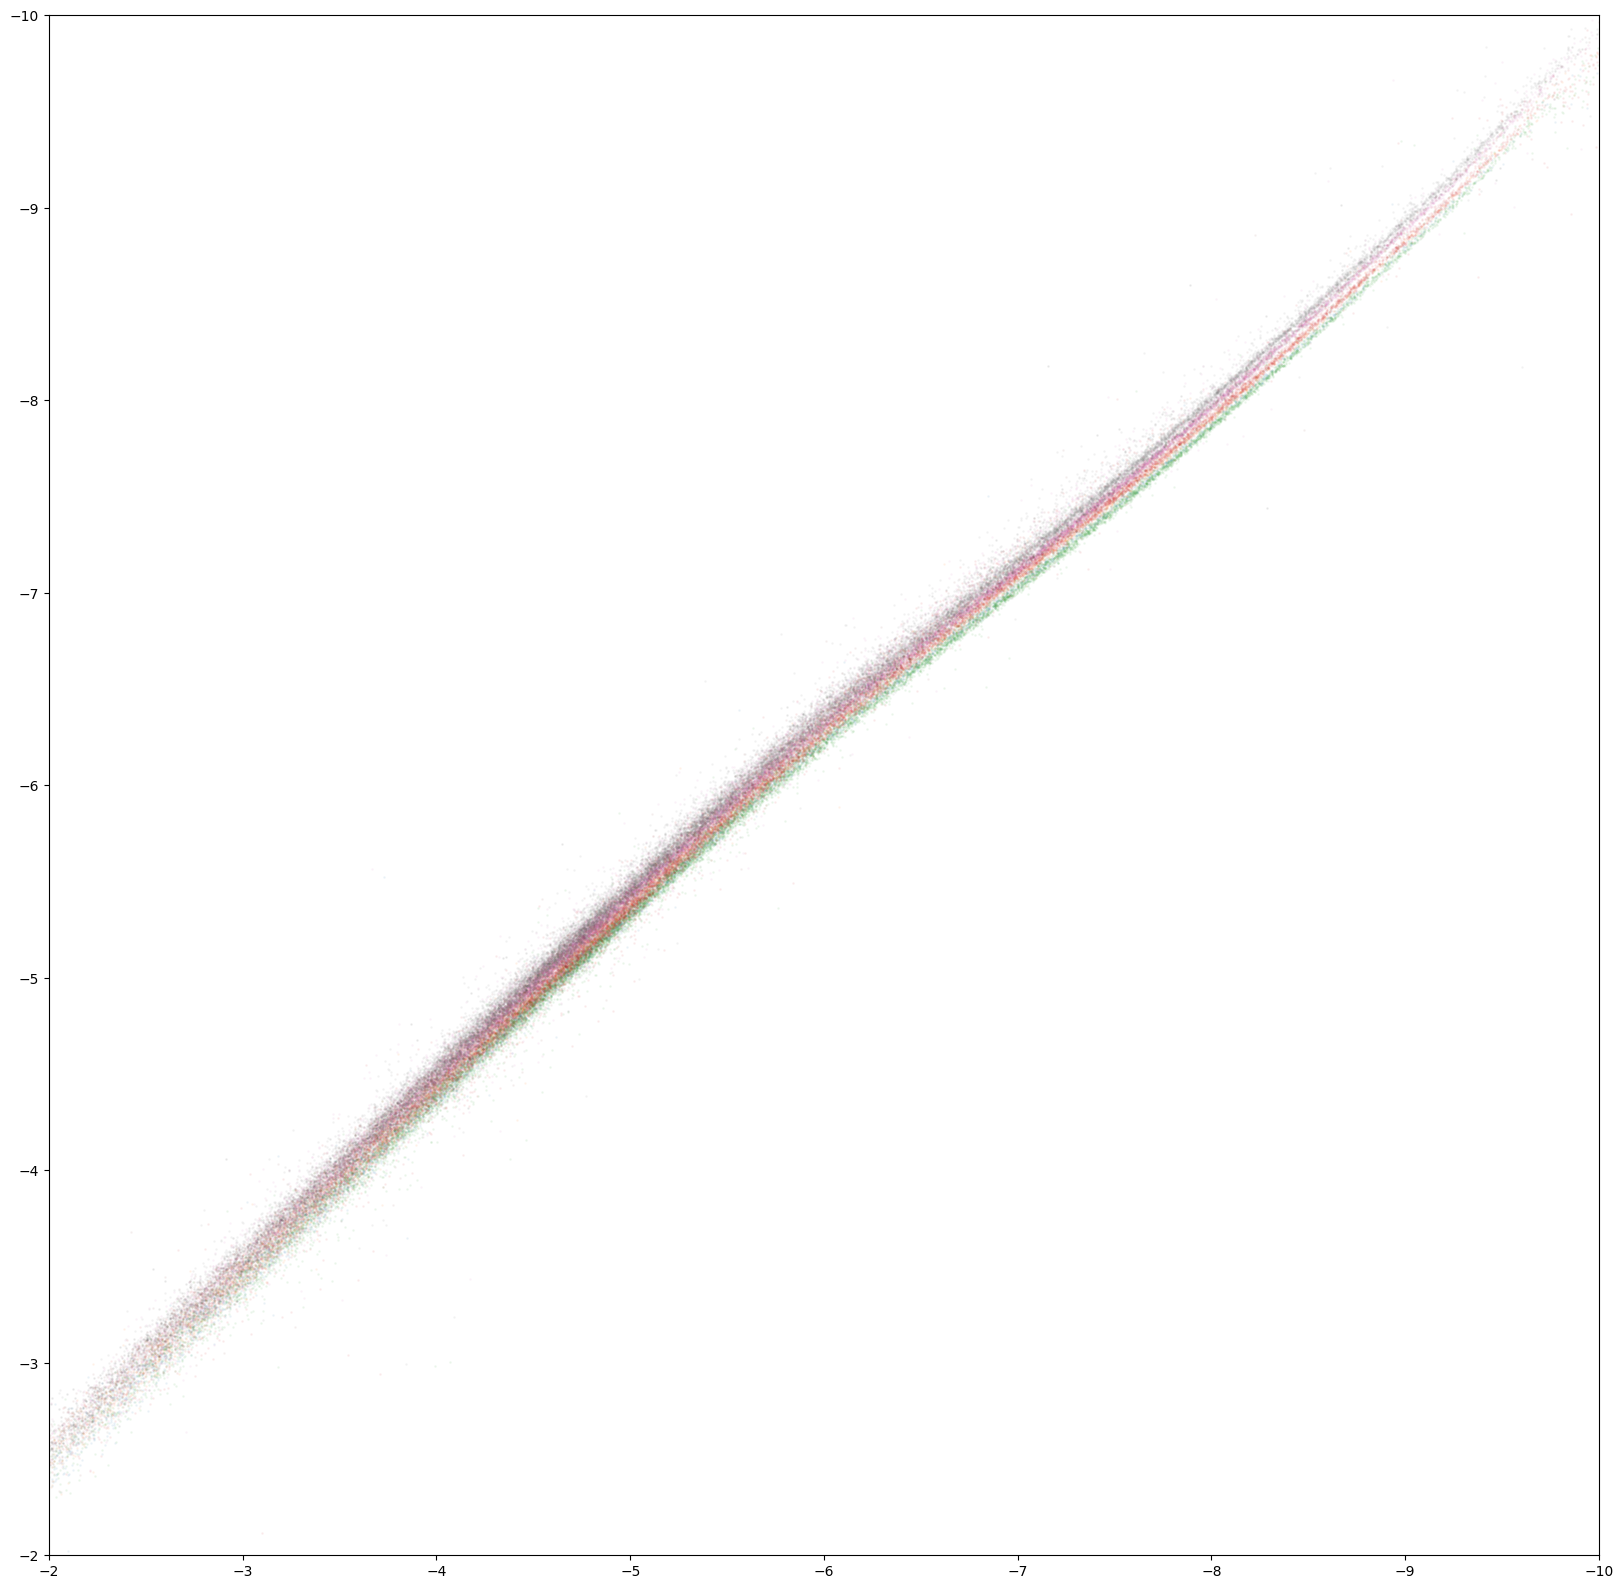

In [37]:
mag090 = m92_cat['F090W_mbar']
mag150 = m92_cat['F150W_mbar']

plt.figure(figsize=(20, 20))
for i,c in enumerate(list(np.unique(m92_cat['chipnum_090']))):
    msk = (mag090!=0) & (mag150!=0) & (m92_cat['chipnum_090']==c)
    
    plt.scatter(mag090[msk], mag150[msk], s=1, alpha=.05, c='k' if c=='b1' else f'C{i}')
plt.xlim(-2, -10)
plt.ylim(-2, -10)

plt.savefig('beforecorr.png')

In [6]:
bw = .02

msk = (mag090!=0) & (mag150!=0) & (m92_cat['chipnum_090']=='b1')
refm1 = mag090[msk]
refm2 = mag150[msk]
kdeb1 = gaussian_kde([refm1, refm2], bw_method=bw)

msk = (mag090!=0) & (mag150!=0) & (m92_cat['chipnum_090']=='a1')
kdea1 = gaussian_kde([mag090[msk], mag150[msk]], bw_method=bw)

Use b1 as the reference because it has the best calibration from the pipeline

In [7]:
def resid(dd):
    d1, d2 = dd

    k1vals = kdeb1.evaluate((refm1, refm2))
    k2vals = kdea1.evaluate((refm1 + d1, refm2 + d2))

    return (k1vals - k2vals)**2

  0%|          | 0/144 [00:00<?, ?it/s]

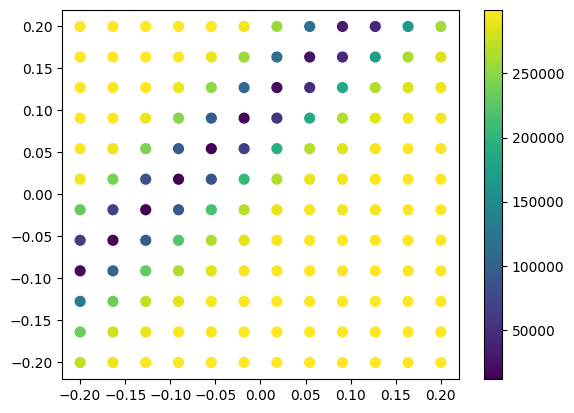

In [8]:
dxg, dyg = np.mgrid[-.2:.2:12j, -.2:.2:12j]
res = []
for xi, yi in tqdm(list(zip(dxg.ravel(), dyg.ravel()))):
    res.append(np.sum(resid((xi, yi))**2))
plt.scatter(dxg.ravel(), dyg.ravel(), c=res, s=50)
plt.colorbar()

In [44]:
%%time

res = least_squares(resid, (0,0), bounds=([-.5,-.5], [.5,.5]))

CPU times: user 55 s, sys: 9 s, total: 1min 3s
Wall time: 52.3 s


In [45]:
%%time

res2 = leastsq(resid, (0,0))

CPU times: user 49.1 s, sys: 4.52 ms, total: 49.1 s
Wall time: 49.1 s


In [47]:
res.x, res2

(array([-0.13412549, -0.11943203]), (array([-0.13410303, -0.11941171]), 1))

Now try scaling up to all chip segments, using leastsq

** Note ** Skip next three cells if you don't want to wait for the calculation but instead want to use the pickle

In [22]:
chips = list(np.unique(m92_cat['chipnum_090']))
chips.remove('b1')

def resid_general(dd, kde2):
    d1, d2 = dd

    k1vals = kdeb1.evaluate((refm1, refm2))
    k2vals = kde2.evaluate((refm1 + d1, refm2 + d2))

    return (k1vals - k2vals)**2

In [57]:
kde_chips = {}
results = {}
for chip in tqdm(chips):
    msk = (mag090!=0) & (mag150!=0) & (m92_cat['chipnum_090']==chip)
    kde_chips[chip] = kde_chip = gaussian_kde([mag090[msk], mag150[msk]], bw_method=bw)
    results[chip] = leastsq(resid_general, (0,0), args=kde_chip, full_output=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [67]:
with open('res.pickle', 'wb') as f:
    pickle.dump(results, f)
for k,v in results.items():
    print(k)
    print(v[0])
    print(v[1]**0.5)

a1
[-0.13410303 -0.11941171]
[[0.00081597 0.00077705]
 [0.00077705 0.00074109]]
a2
[-0.15695605 -0.07387742]
[[0.00059054 0.00056216]
 [0.00056216 0.00053591]]
a3
[-0.23574636 -0.18296586]
[[0.00112563 0.00106896]
 [0.00106896 0.00101675]]
a4
[-0.31884427 -0.22728948]
[[0.0009342  0.00088392]
 [0.00088392 0.00083905]]
b2
[0.00239306 0.00897732]
[[0.00068304 0.00064953]
 [0.00064953 0.00061858]]
b3
[-0.09911014 -0.07965943]
[[0.00103263 0.00097824]
 [0.00097824 0.00092846]]
b4
[-0.10013029 -0.13190275]
[[0.00103785 0.00098473]
 [0.00098473 0.00093701]]


you can run this next cell *instead* of the above two cells:

In [9]:
with open('res.pickle', 'rb') as f:
    results = pickle.load(f)
for k,v in results.items():
    print(k)
    print(v[0])
    print(v[1]**0.5)

a1
[-0.13410303 -0.11941171]
[[0.00081597 0.00077705]
 [0.00077705 0.00074109]]
a2
[-0.15695605 -0.07387742]
[[0.00059054 0.00056216]
 [0.00056216 0.00053591]]
a3
[-0.23574636 -0.18296586]
[[0.00112563 0.00106896]
 [0.00106896 0.00101675]]
a4
[-0.31884427 -0.22728948]
[[0.0009342  0.00088392]
 [0.00088392 0.00083905]]
b2
[0.00239306 0.00897732]
[[0.00068304 0.00064953]
 [0.00064953 0.00061858]]
b3
[-0.09911014 -0.07965943]
[[0.00103263 0.00097824]
 [0.00097824 0.00092846]]
b4
[-0.10013029 -0.13190275]
[[0.00103785 0.00098473]
 [0.00098473 0.00093701]]


(-2.0, -10.0)

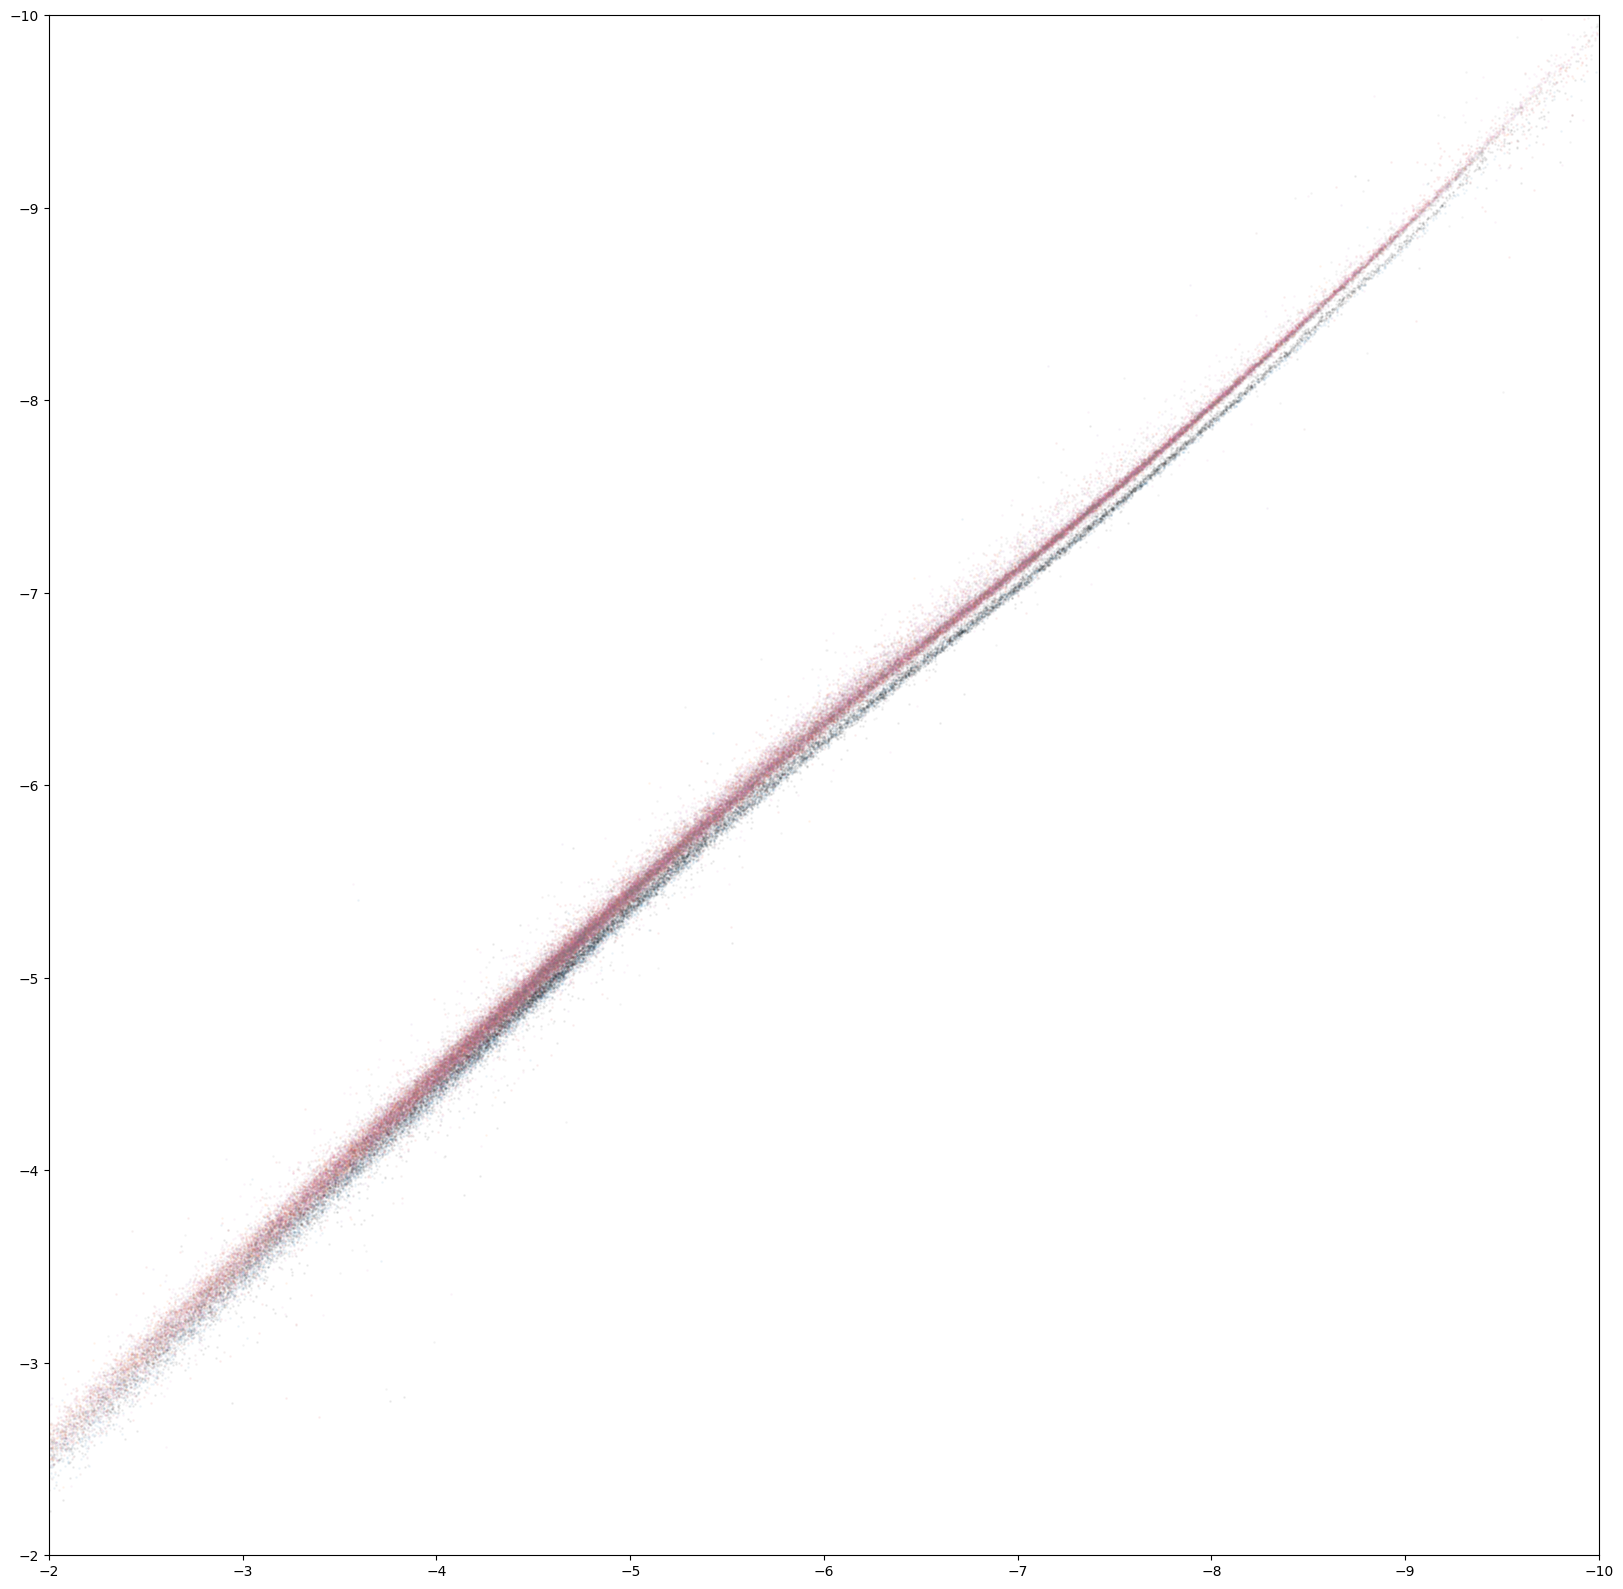

In [18]:
mag090 = m92_cat['F090W_mbar']
mag150 = m92_cat['F150W_mbar']

plt.figure(figsize=(20, 20))
for i,c in enumerate(list(np.unique(m92_cat['chipnum_090']))):
    msk = (mag090!=0) & (mag150!=0) & (m92_cat['chipnum_090']==c)
    if c == 'b1':
        d090 = d150 = 0
    else:
        d090 = results[c][0][0]
        d150 = results[c][0][1]
    
    plt.scatter(mag090[msk] - d090, mag150[msk] - d150, s=1, alpha=.05, c=f'C{i}' if c!='a3' else 'k')
plt.xlim(-2, -10)
plt.ylim(-2, -10)

all but a3 are good.  Tweak a bit by hand? It seems to need the largest offset so maybe not a surprise

In [28]:
chip = 'a3'

msk = (mag090!=0) & (mag150!=0) & (m92_cat['chipnum_090']==chip)
kde_chip = gaussian_kde([mag090[msk], mag150[msk]], bw_method=bw)
result = leastsq(resid_general, (.2,.2), args=kde_chip, full_output=True)

results[chip] = result
result

(array([-0.1370881 , -0.01101127]),
 None,
 {'fvec': array([0.1206176 , 0.29092358, 0.1427307 , ..., 0.0545714 , 0.15776377,
         0.07574516]),
  'nfev': 601,
  'fjac': array([[-1.66855352e+04, -9.78511764e-03, -9.22067953e-03, ...,
          -8.50776426e-04, -3.69839186e-04, -6.94993490e-03],
         [ 1.50210966e+04, -9.43458512e+02,  1.27392578e-02, ...,
          -5.26914355e-04,  1.72171167e-04, -1.61316774e-03]]),
  'ipvt': array([2, 1], dtype=int32),
  'qtf': array([ 0.01776502, -0.00687466])},
 'Number of calls to function has reached maxfev = 600.',
 5)

(-2.0, -10.0)

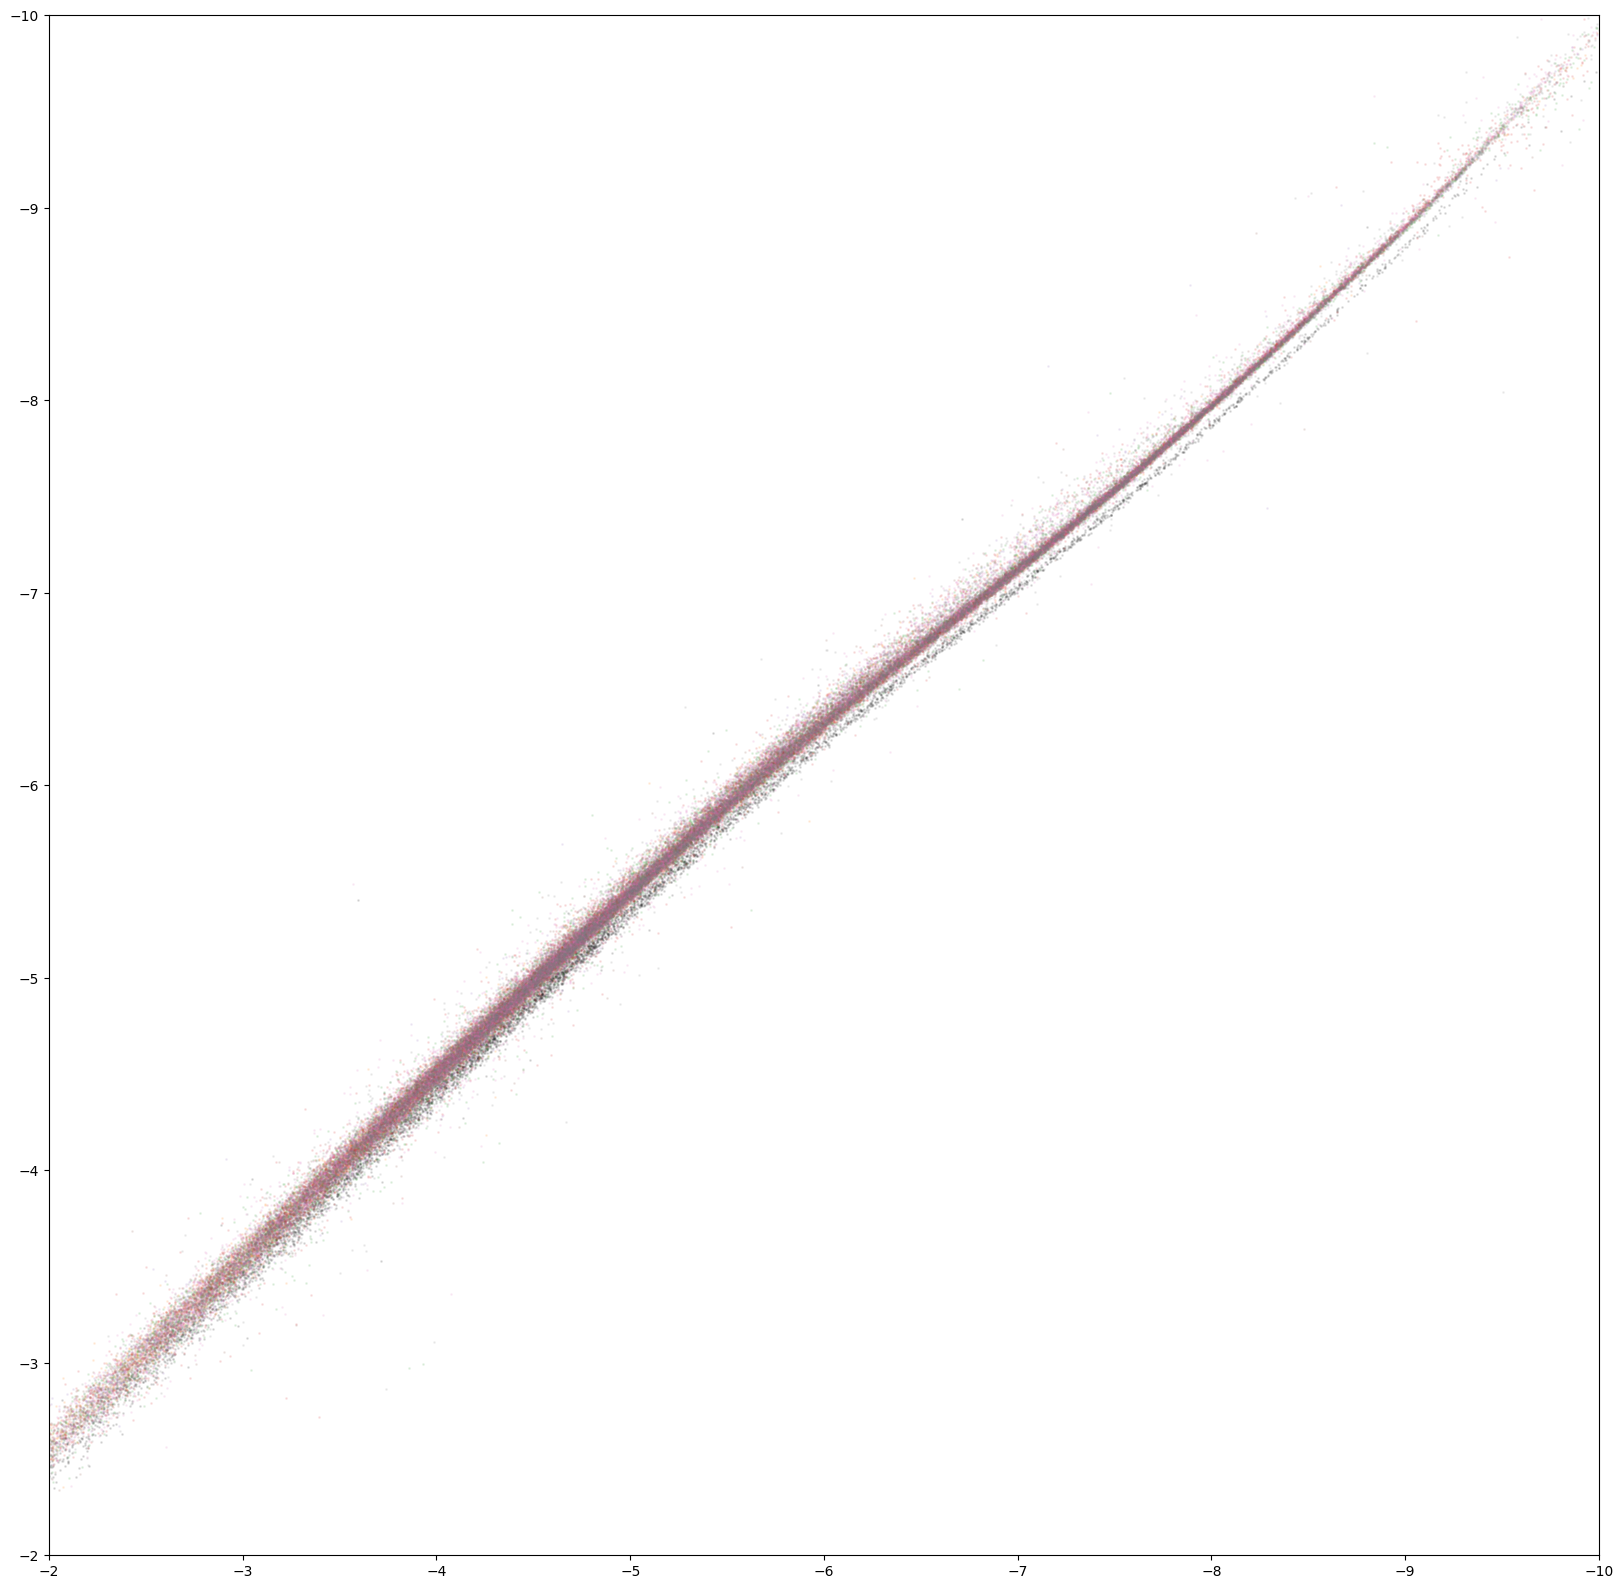

In [33]:
mag090 = m92_cat['F090W_mbar']
mag150 = m92_cat['F150W_mbar']

plt.figure(figsize=(20, 20))
for i,c in enumerate(list(np.unique(m92_cat['chipnum_090']))):
    msk = (mag090!=0) & (mag150!=0) & (m92_cat['chipnum_090']==c)
    if c == 'b1':
        d090 = d150 = 0
    else:
        d090 = results[c][0][0]
        d150 = results[c][0][1]
    
    plt.scatter(mag090[msk] - d090, mag150[msk] - d150, s=1, alpha=.1, c=f'C{i}' if c!='a1' else 'k')
plt.xlim(-2, -10)
plt.ylim(-2, -10)

Turns out a1 is also an issue... 

In [34]:
chip = 'a1'

msk = (mag090!=0) & (mag150!=0) & (m92_cat['chipnum_090']==chip)
kde_chip = gaussian_kde([mag090[msk], mag150[msk]], bw_method=bw)
result = leastsq(resid_general, (.2,.2), args=kde_chip, full_output=True)

results[chip] = result
result

(array([-0.16719877, -0.05122679]),
 array([[3.75102826e-07, 3.39039040e-07],
        [3.39039040e-07, 3.07504944e-07]]),
 {'fvec': array([0.29771559, 0.1476171 , 0.999036  , ..., 0.58875825, 0.08358702,
         0.14135492]),
  'nfev': 589,
  'fjac': array([[-3.06802861e+04, -9.37732626e-03, -7.41111044e-03, ...,
          -1.97646669e-03,  2.13103654e-03, -6.31459056e-04],
         [ 2.77305689e+04, -1.63276932e+03, -1.08622453e-02, ...,
           6.12719741e-04, -1.20618231e-04,  6.09153199e-03]]),
  'ipvt': array([2, 1], dtype=int32),
  'qtf': array([0.00659141, 0.00399327])},
 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000',
 1)

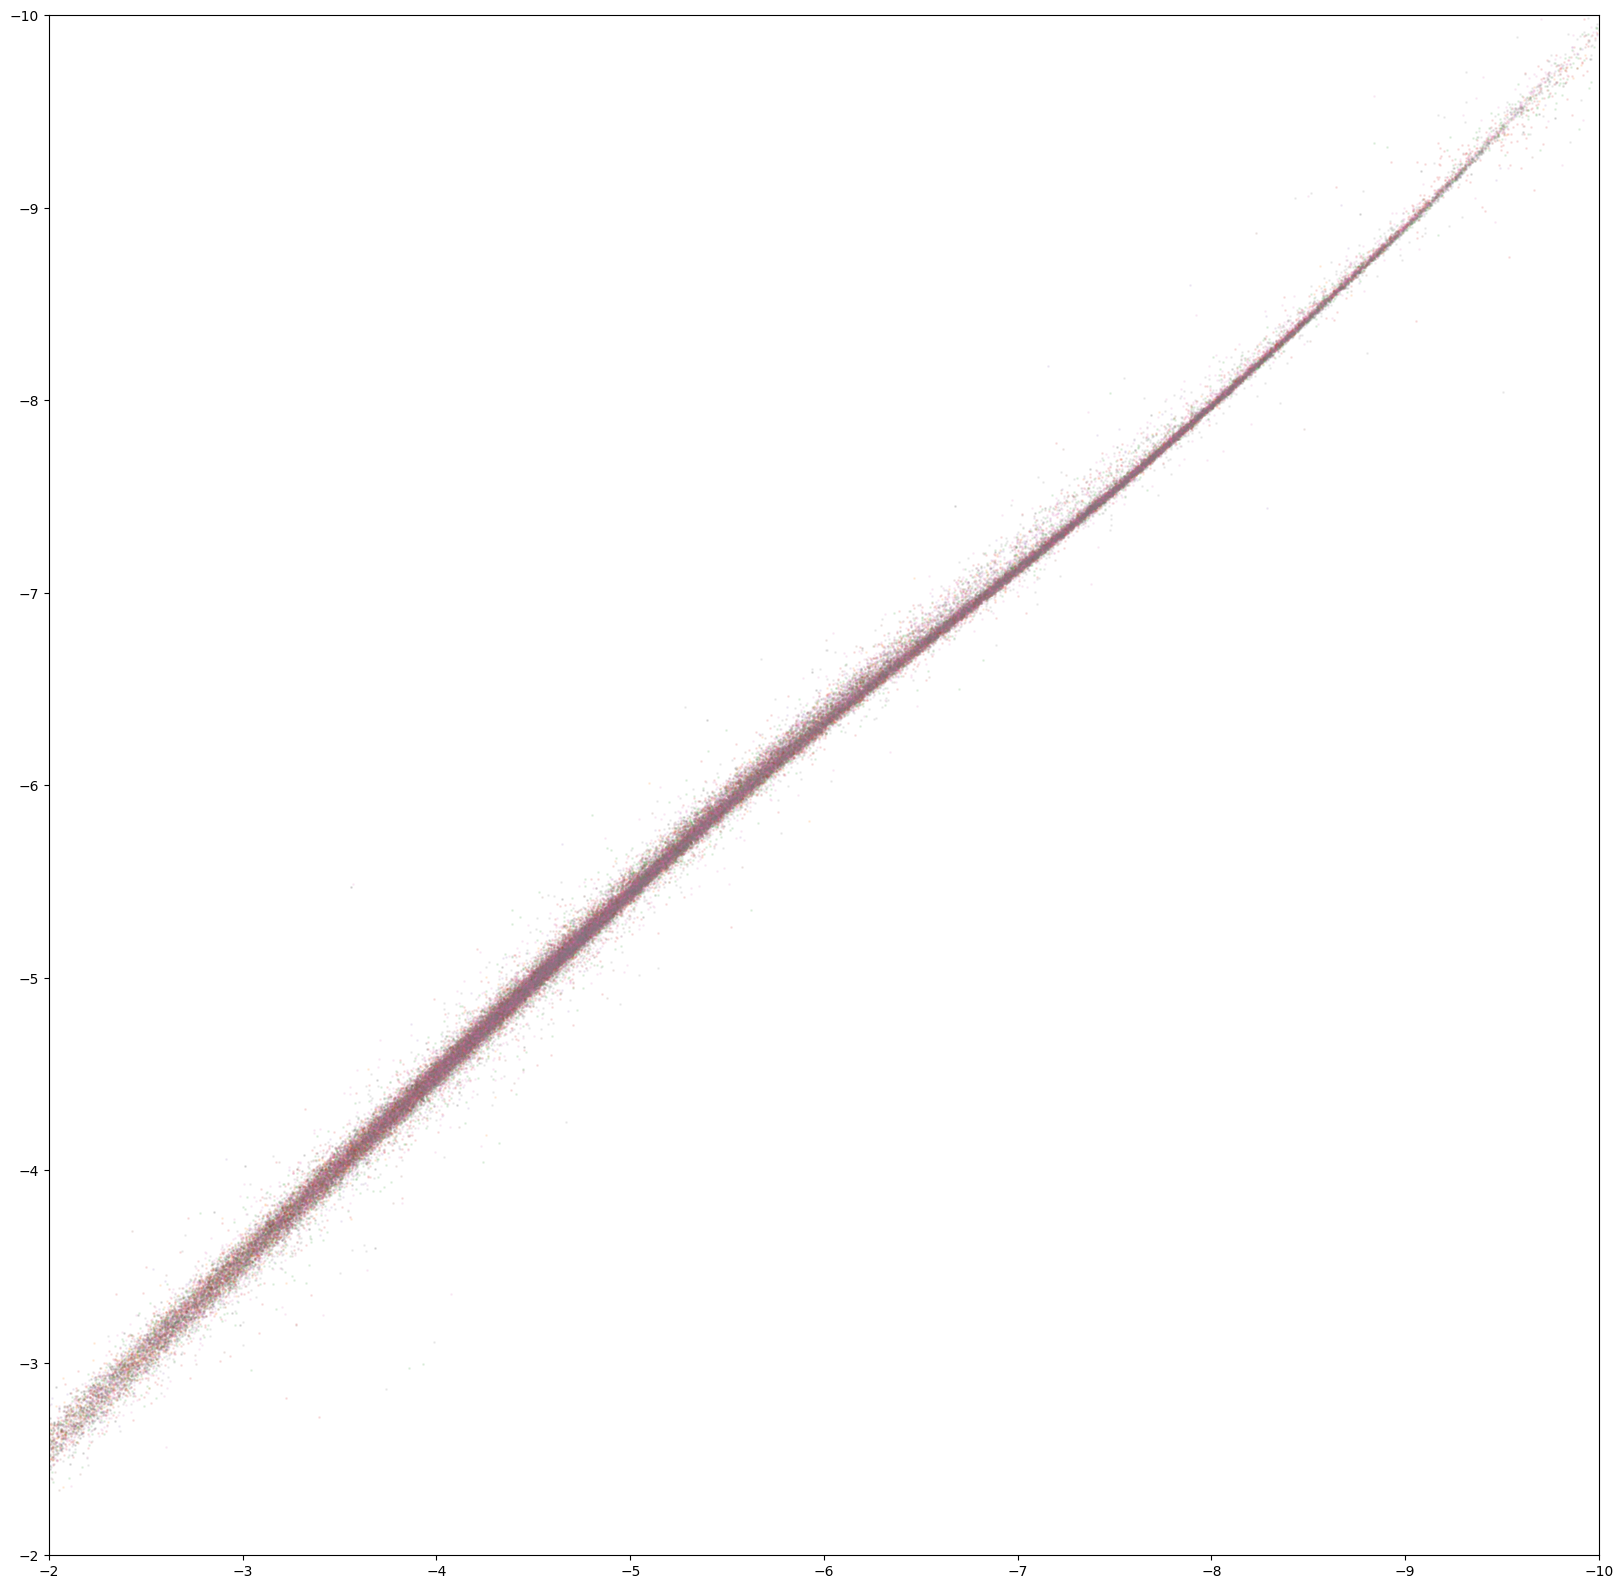

In [39]:
mag090 = m92_cat['F090W_mbar']
mag150 = m92_cat['F150W_mbar']

plt.figure(figsize=(20, 20))
for i,c in enumerate(list(np.unique(m92_cat['chipnum_090']))):
    msk = (mag090!=0) & (mag150!=0) & (m92_cat['chipnum_090']==c)
    if c == 'b1':
        d090 = d150 = 0
    else:
        d090 = results[c][0][0]
        d150 = results[c][0][1]
    
    plt.scatter(mag090[msk] - d090, mag150[msk] - d150, s=1, alpha=.1, c=f'C{i}' if c!='a1' else 'k')
plt.xlim(-2, -10)
plt.ylim(-2, -10)

plt.savefig('aftercorr.png')

(-7.0, -11.0)

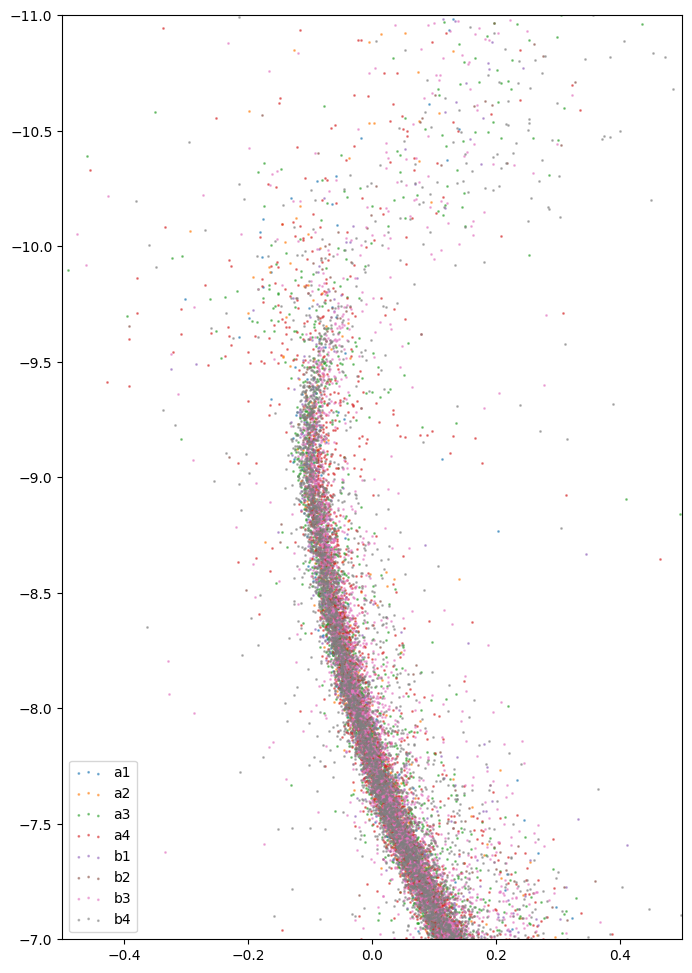

In [53]:
mag090 = m92_cat['F090W_mbar']
mag150 = m92_cat['F150W_mbar']

plt.figure(figsize=(8, 12))
for i,c in enumerate(list(np.unique(m92_cat['chipnum_090']))):
    msk = (mag090!=0) & (mag150!=0) & (m92_cat['chipnum_090']==c)
    if c == 'b1':
        d090 = d150 = 0
    else:
        d090 = results[c][0][0]
        d150 = results[c][0][1]
    m1 = mag090[msk] - d090
    m2 = mag150[msk] - d150
    
    plt.scatter(m1-m2, m1, s=1, alpha=.5, c=f'C{i}', label=c)

plt.legend(loc=0, scatterpoints=3)
plt.xlim(-.5, .5)
plt.ylim(-7, -11)

Now render in Jay's offset format

In [59]:
print('F090W_mbar b1 0')
print('F150W_mbar b1 0')
for chipnm, res in results.items():
    d090, d150 = res[0]
    print(f'F090W_mbar {chipnm} {d090}')
    print(f'F150W_mbar {chipnm} {d150}')

F090W_mbar b1 0
F150W_mbar b1 0
F090W_mbar a1 -0.16719876900691585
F150W_mbar a1 -0.05122679141284408
F090W_mbar a2 -0.1569560501933958
F150W_mbar a2 -0.0738774221927598
F090W_mbar a3 -0.13708810315479308
F150W_mbar a3 -0.01101127104454172
F090W_mbar a4 -0.31884426914090797
F150W_mbar a4 -0.2272894776957764
F090W_mbar b2 0.0023930579189923662
F150W_mbar b2 0.008977319777346813
F090W_mbar b3 -0.09911013992416183
F150W_mbar b3 -0.07965943032107568
F090W_mbar b4 -0.1001302859442727
F150W_mbar b4 -0.13190274806279345


In [83]:
jayoff = Table.read("""F150W_mbar a1  -5.11
F150W_mbar a2  -5.15
F150W_mbar a3  -5.14
F150W_mbar a4  -5.21
F150W_mbar b1  -5.10
F150W_mbar b2  -5.12
F150W_mbar b3  -5.22
F150W_mbar b4  -5.26
F090W_mbar a1  -4.74
F090W_mbar a2  -4.75
F090W_mbar a3  -4.80
F090W_mbar a4  -4.82
F090W_mbar b1  -4.63
F090W_mbar b2  -4.65
F090W_mbar b3  -4.76
F090W_mbar b4  -4.76""", format='ascii')

f150msk = jayoff['col1']=='F150W_mbar'
b2_150_0 = jayoff[f150msk&(jayoff['col2']=='b1')]['col3'][0]
b2_090_0 = jayoff[~f150msk&(jayoff['col2']=='b1')]['col3'][0]

jayoff['col3'][f150msk] -= b2_150_0
jayoff['col3'][~f150msk] -= b2_090_0

jayoff.show_in_notebook()

idx,col1,col2,col3
0,F150W_mbar,a1,-0.010000000000000675
1,F150W_mbar,a2,-0.05000000000000071
2,F150W_mbar,a3,-0.040000000000000036
3,F150W_mbar,a4,-0.11000000000000032
4,F150W_mbar,b1,0.0
5,F150W_mbar,b2,-0.020000000000000462
6,F150W_mbar,b3,-0.1200000000000001
7,F150W_mbar,b4,-0.16000000000000014
8,F090W_mbar,a1,-0.11000000000000032
9,F090W_mbar,a2,-0.1200000000000001
